<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_rk4_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RK4 solver

We optimizing the inflow rate it is not necessary to evaluate different initial conditions. Only those entered by the user. What we need is to evaluate different inflow rate profiles 

I could use an ANN to model the inflow rate as a function of time

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

In [55]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
import time 
# from torchdyn.numerics.solvers import SolverTemplate

In [40]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [41]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 257 (delta 21), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (257/257), 6.71 MiB | 5.38 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [42]:
cd maestria

/content/maestria


In [43]:
ls

case_studies/  mc_continuous/       ml_batch/            parameter_estimation/
data/          mc_fb/               ml_fb/               README.md
mc_batch/      mc_fb_optimization/  ml_fb_optimization/  utilis/


In [44]:
# Import functions from my utilis package
from utilis.functions import create_initial_cond, plot_trajectory, plot_predictions, create_time_span
from utilis.models import fnn_model, inhibition_model_nn
from utilis.solvers import DirectSolver

1. Create initial conditions for training 
    * 100 initial conditions 
    * biomass concentrations goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentration goes from 0 to 40 g/L

In [45]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 9.8, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 7.5634, 27.0863,  7.5596],
        [ 6.4288, 35.3024, 18.5298],
        [ 8.1307, 17.4045, 19.2325],
        [ 7.8068, 36.9619, 30.5050],
        [ 4.3118, 23.6253,  5.1855]], dtype=torch.float64)
torch.Size([100, 3])


2. Create initial conditions for validation 
    * 100 initial conditions 
    * biomass concentrations goes from 1 to 6 g/L
    * substrate concentration goes from 15 to 35 g/L
    * product concentration goes from 0 to 0 g/L

In [46]:
# Initial conditions to model validation
# x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
x0_validate = create_initial_cond(10, 1, 5, 15, 20, 0, 0)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 4.5864, 17.6945,  0.0000],
        [ 4.0680, 30.3357,  0.0000],
        [ 5.4691, 15.3016,  0.0000],
        [ 1.7750, 23.4071,  0.0000],
        [ 3.3946, 22.5651,  0.0000]], dtype=torch.float64)
torch.Size([10, 3])


3. Create time span for training
    * Time span for training is of one hour

4. Create time span for validations 
    * Time span for validations is of sixty hours

In [47]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

5. Generate training trajectories
    * Each training trajectory consists of two observations, the initial condition and one step haead 

In [48]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")

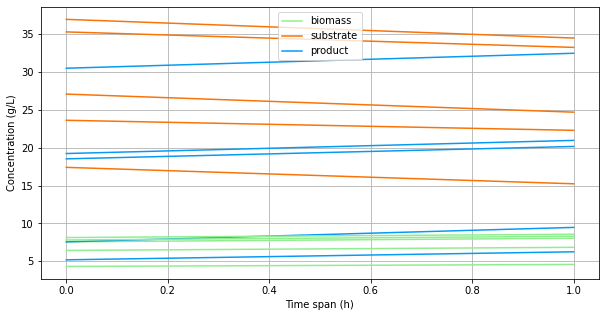

In [49]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

6. Generate validations trajectories
    * Each validations trajectory consists of sixty one observations, the initial contition and sixty steps haead

In [50]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

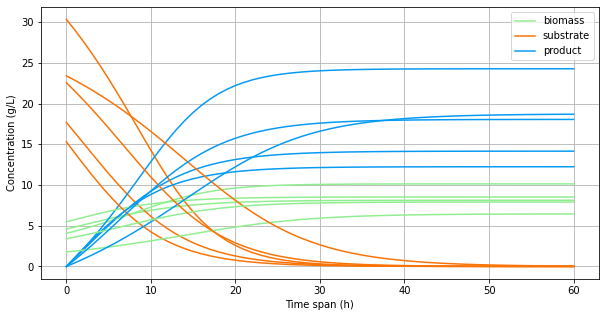

In [51]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

7. Create ANN model
    * The input layers contains three neurons. It is a simple linear layer without activation function 
    * There exist eight hidden layers, each with thirty two neurons. Each hidden layer consist of a linear layer with a softplus acttivation function 
    * the output layer has three neurons and it is a simple linear layr without activation function
    * The weights and biases are randomly initialized 

In [53]:
# Create model
net = fnn_model(3, 3, 32, 8)

8. The training algorithm is Adam

In [54]:
# training algorithm
optimizer = Adam(net.parameters()) 

9. During training
    * The training occurs for 2000 epochs 
    * The loss function is MSE
    * There is no inference phase during training 

In [56]:
start_time = time.time()
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver='rk4'
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    # net.eval()
    # with torch.inference_mode():

    #     # 1. Forward pass
    #     _, x_pred_validate = odeint(
    #         lambda t, x: net(x), 
    #         x0_validate, 
    #         t_span_validate, 
    #         solver='rk4'
    #     )

    #     # 2. Calculate loss
    #     loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:
        # print(f"Epoch: {epoch} | Training loss: {loss} | Validation loss: {loss_val}")
        print(f"Epoch: {epoch} | Training loss: {loss}")
end_time = time.time()

  1%|          | 18/2000 [00:00<00:22, 87.77it/s]

Epoch: 0 | Training loss: 1.8435190068149192


  4%|▎         | 71/2000 [00:00<00:18, 102.41it/s]

Epoch: 50 | Training loss: 0.05205213189496178


  6%|▌         | 115/2000 [00:01<00:18, 99.47it/s] 

Epoch: 100 | Training loss: 0.0023333749986508816


  9%|▊         | 171/2000 [00:01<00:17, 105.52it/s]

Epoch: 150 | Training loss: 0.0010485031939120137


 11%|█         | 215/2000 [00:02<00:18, 98.30it/s] 

Epoch: 200 | Training loss: 0.0006398347437158231


 14%|█▎        | 271/2000 [00:02<00:16, 105.88it/s]

Epoch: 250 | Training loss: 0.00042300238288387913


 16%|█▌        | 315/2000 [00:03<00:17, 98.30it/s] 

Epoch: 300 | Training loss: 0.00032863782871724164


 18%|█▊        | 370/2000 [00:03<00:15, 104.22it/s]

Epoch: 350 | Training loss: 0.00023156910258686778


 21%|██        | 415/2000 [00:04<00:14, 106.24it/s]

Epoch: 400 | Training loss: 0.00019891641358974583


 24%|██▎       | 471/2000 [00:04<00:14, 104.69it/s]

Epoch: 450 | Training loss: 0.00014589435502515615


 26%|██▌       | 516/2000 [00:05<00:14, 103.38it/s]

Epoch: 500 | Training loss: 0.00014975266921421503


 28%|██▊       | 561/2000 [00:05<00:13, 103.21it/s]

Epoch: 550 | Training loss: 9.984195825781227e-05


 31%|███       | 617/2000 [00:06<00:14, 96.46it/s] 

Epoch: 600 | Training loss: 8.502183341239992e-05


 33%|███▎      | 669/2000 [00:06<00:13, 98.72it/s]

Epoch: 650 | Training loss: 0.00010582465660060105


 36%|███▌      | 714/2000 [00:07<00:12, 104.75it/s]

Epoch: 700 | Training loss: 6.53287923304396e-05


 38%|███▊      | 770/2000 [00:07<00:11, 105.56it/s]

Epoch: 750 | Training loss: 0.00013489779511417806


 41%|████      | 816/2000 [00:08<00:11, 106.20it/s]

Epoch: 800 | Training loss: 5.355421598808796e-05


 44%|████▎     | 872/2000 [00:08<00:10, 104.64it/s]

Epoch: 850 | Training loss: 4.5892754261789366e-05


 46%|████▌     | 917/2000 [00:08<00:10, 106.80it/s]

Epoch: 900 | Training loss: 0.00020415058683464883


 48%|████▊     | 962/2000 [00:09<00:09, 104.14it/s]

Epoch: 950 | Training loss: 3.894692502016999e-05


 51%|█████     | 1019/2000 [00:09<00:09, 108.85it/s]

Epoch: 1000 | Training loss: 3.487768383546455e-05


 53%|█████▎    | 1063/2000 [00:10<00:08, 104.65it/s]

Epoch: 1050 | Training loss: 3.1448577001037445e-05


 56%|█████▌    | 1120/2000 [00:10<00:07, 110.23it/s]

Epoch: 1100 | Training loss: 6.058340397193993e-05


 58%|█████▊    | 1165/2000 [00:11<00:07, 105.15it/s]

Epoch: 1150 | Training loss: 4.3020345243154735e-05


 61%|██████    | 1222/2000 [00:11<00:07, 107.05it/s]

Epoch: 1200 | Training loss: 2.6261798374883997e-05


 63%|██████▎   | 1268/2000 [00:12<00:06, 110.02it/s]

Epoch: 1250 | Training loss: 2.3949613638316135e-05


 66%|██████▌   | 1315/2000 [00:12<00:06, 107.55it/s]

Epoch: 1300 | Training loss: 2.210856091866905e-05


 68%|██████▊   | 1370/2000 [00:13<00:06, 101.76it/s]

Epoch: 1350 | Training loss: 2.0559119454044672e-05


 71%|███████   | 1415/2000 [00:13<00:05, 104.80it/s]

Epoch: 1400 | Training loss: 7.855717162538578e-05


 74%|███████▎  | 1471/2000 [00:14<00:05, 105.78it/s]

Epoch: 1450 | Training loss: 2.011237299552883e-05


 76%|███████▌  | 1515/2000 [00:14<00:04, 104.24it/s]

Epoch: 1500 | Training loss: 1.821571570796672e-05


 79%|███████▊  | 1571/2000 [00:15<00:04, 104.76it/s]

Epoch: 1550 | Training loss: 1.6951224862441697e-05


 81%|████████  | 1616/2000 [00:15<00:03, 104.60it/s]

Epoch: 1600 | Training loss: 1.585165426143479e-05


 84%|████████▎ | 1674/2000 [00:16<00:02, 109.00it/s]

Epoch: 1650 | Training loss: 4.011584476861484e-05


 86%|████████▌ | 1718/2000 [00:16<00:02, 102.06it/s]

Epoch: 1700 | Training loss: 3.252124350783157e-05


 88%|████████▊ | 1765/2000 [00:17<00:02, 109.17it/s]

Epoch: 1750 | Training loss: 1.4919326315911032e-05


 91%|█████████ | 1820/2000 [00:17<00:01, 103.33it/s]

Epoch: 1800 | Training loss: 1.3803076859825589e-05


 93%|█████████▎| 1865/2000 [00:17<00:01, 106.23it/s]

Epoch: 1850 | Training loss: 1.290489538624343e-05


 96%|█████████▌| 1917/2000 [00:18<00:00, 98.72it/s]

Epoch: 1900 | Training loss: 1.212119480441397e-05


 98%|█████████▊| 1963/2000 [00:18<00:00, 106.96it/s]

Epoch: 1950 | Training loss: 1.141671953838917e-05


100%|██████████| 2000/2000 [00:19<00:00, 103.66it/s]


10. The minimum training loss functions value was 1.508e-5

11. The time required for training withoput inference phase was 19.022 seconds

In [57]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 19.304s


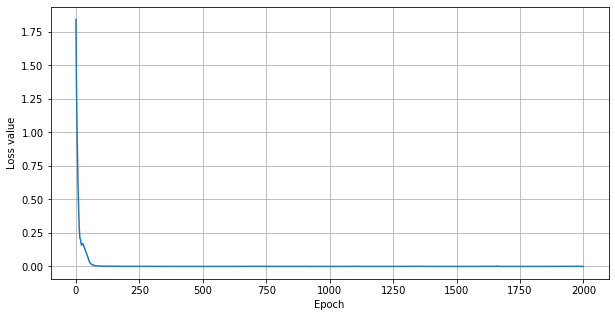

In [58]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [59]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver='rk4'
    ) 

In [60]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


12. The minimum validations loss function value was 0.149 

In [61]:
mse_loss(x_pred_validate, x_validate) 

tensor(0.2347, dtype=torch.float64)

Validations loss: 0.1491

In [62]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

Validation 0


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

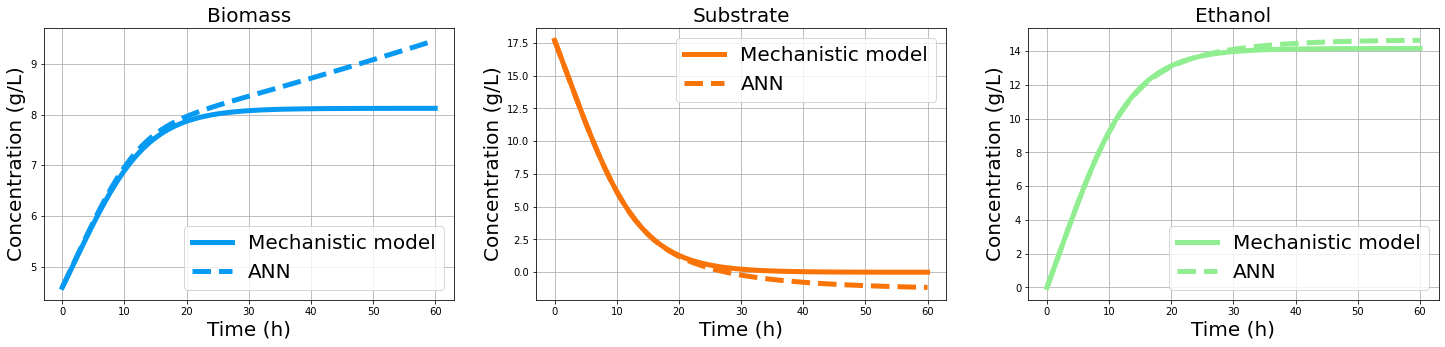

Validation 1


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

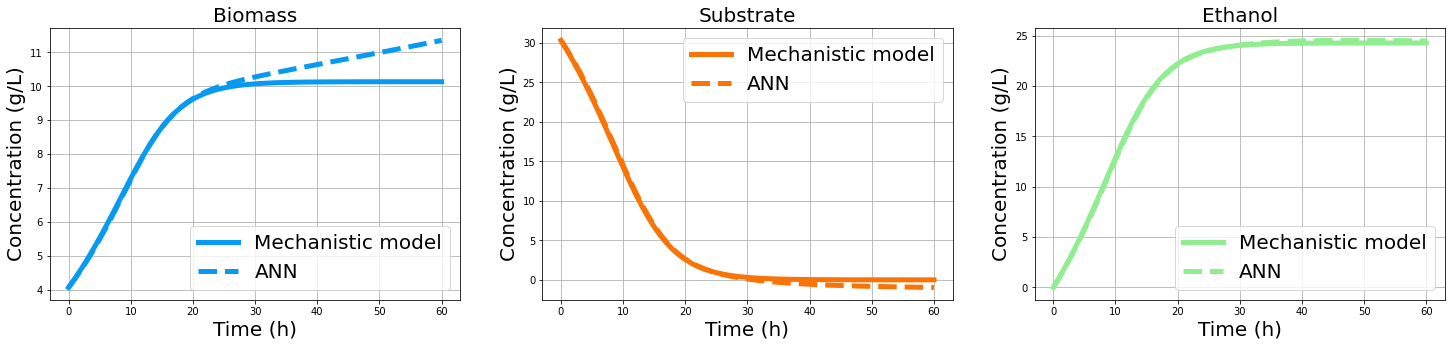

Validation 2


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

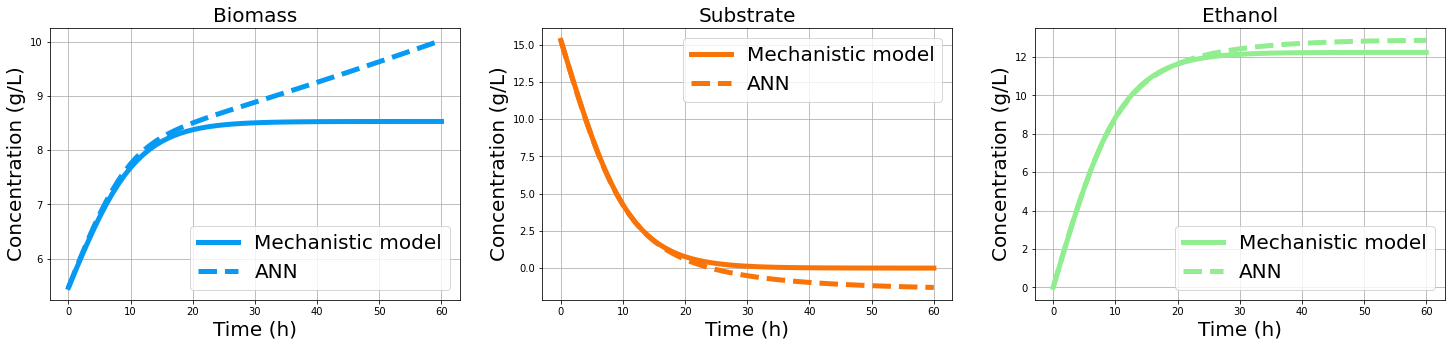

Validation 3


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

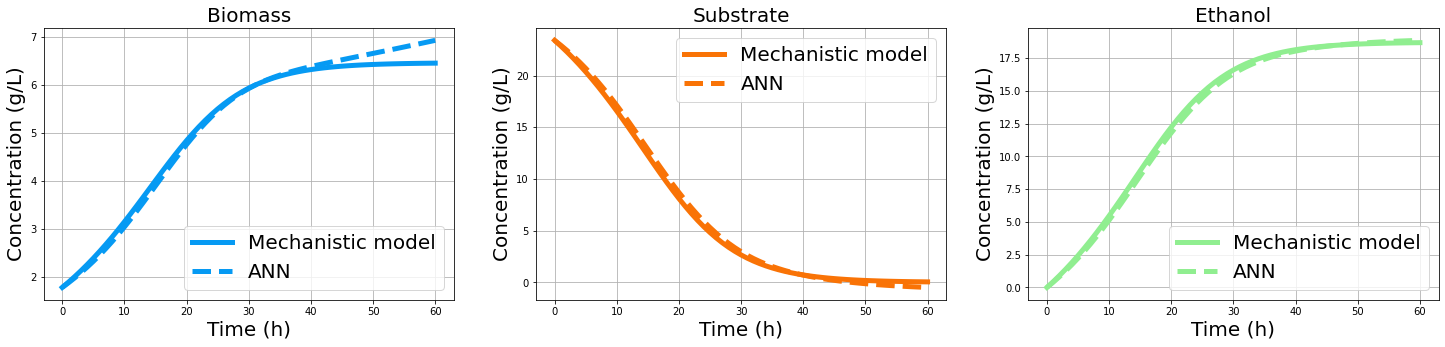

Validation 4


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

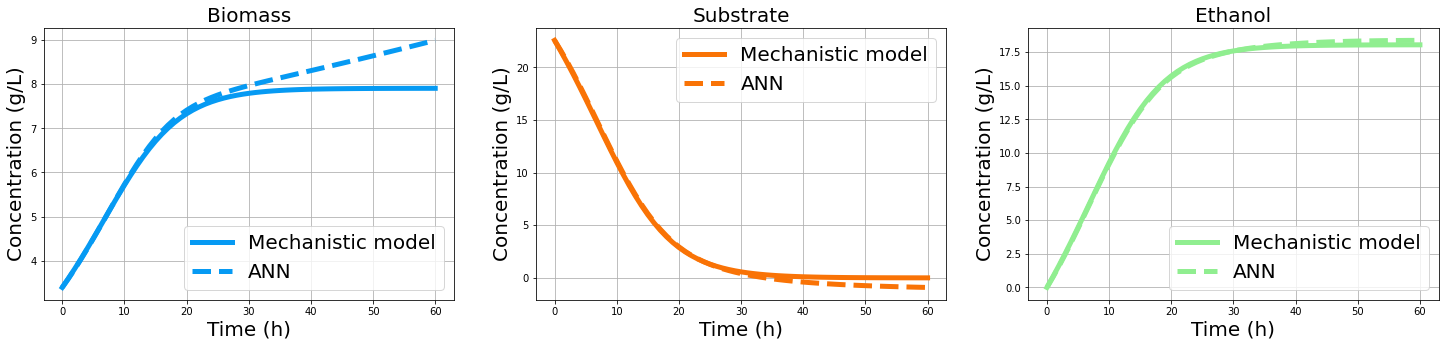

In [64]:
for i in range(5):
    plot_predictions(t_span_validate,x_validate, x_pred_validate,i)